In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Planet Structure

In this notebook we are going to take a look at the equations of state of [Seager et al. (2007)](https://arxiv.org/abs/0707.2895), which are more realistic than the constant density approach we took in the lectures. These equations of state take the form \\[ \rho(P) = \rho_0 + cP^n,\\] for some constants \(\rho_0\), \(c\) and \(n\) that take different values for different materials. The high-mass end of the water equation of state is explored in Exercise Sheet 3 ('Water Worlds'). 

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, update_display, HTML
import ipywidgets as widgets

from planet import planet as pl

# Try and make plots look nice
plt.rcParams["font.family"] = 'serif'
plt.rcParams["mathtext.fontset"] = 'stix'
plt.rcParams["font.serif"] = 'Palatino'
plt.rcParams['pdf.fonttype'] = 42
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')

me = 5.972e24
re = 6.371e6
mjup = 312.0*me
rjup = 6.991e7

p_rock = pl.PolyPlanet(rho0=4260.0, c=0.00127, n=0.549)
p_water = pl.PolyPlanet(rho0=1460.0, c=0.00311, n=0.513)
p_iron = pl.PolyPlanet(rho0=8300.0, c=0.00349, n=0.528)


import xml.etree.ElementTree as ET, urllib.request, gzip, io
url = "https://github.com/OpenExoplanetCatalogue/oec_gzip/raw/master/systems.xml.gz"
oec = ET.parse(gzip.GzipFile(fileobj=io.BytesIO(urllib.request.urlopen(url).read())))

def read_oec(oec, str1, str2):
    x = []
    y = []
    names = []

    print_flag = True 
    for planet in oec.findall(".//planet"):
        if (planet.findtext(str1) is not None and
            planet.findtext(str2) is not None and
            planet.findtext(str1) != '' and
            planet.findtext(str2) != ''):

            #if print_flag is True:
            #    for child in planet:
            #        if child.tag == 'mass':
            #            print(child.text, child.attrib)
            #print_flag = False
                
            x.append(float(planet.findtext(str1)))
            y.append(float(planet.findtext(str2)))
            names.append(planet.findtext("name"))

    return x, y, names

class ScatterPlot():
    def __init__(self, fig, ax, x, y, names):
        self.fig = fig
        self.ax = ax

        self.x = x
        self.y = y
        self.names = names

        self.sc = self.ax.scatter(x, y)

        self.annot = self.ax.annotate("", xy=(0,0), xytext=(20,20),
                                      textcoords="offset points",
                                      bbox=dict(boxstyle="round", fc="w"),
                                      arrowprops=dict(arrowstyle="->"))
        self.annot.set_visible(False)

        self.fig.canvas.mpl_connect("motion_notify_event", self.hover)

    def update_annot(self, ind):
        pos = self.sc.get_offsets()[ind["ind"][0]]
        self.annot.xy = pos
        text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))),
                               " ".join([self.names[n] for n in ind["ind"]]))
        self.annot.set_text(text)
        #self.annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
        self.annot.get_bbox_patch().set_alpha(0.4)

    def hover(self, event):
        vis = self.annot.get_visible()
        if event.inaxes == self.ax:
            cont, ind = self.sc.contains(event)
            if cont:
                self.update_annot(ind)
                self.annot.set_visible(True)
                self.fig.canvas.draw_idle()
            else:
                if vis:
                    self.annot.set_visible(False)
                    self.fig.canvas.draw_idle()

oec_mass, oec_radius, oec_names = read_oec(oec, 'mass', 'radius')


## Density profiles

First, we take a look at the resulting density profiles. Below, you can vary the central pressure, as well as the material (rock (roughly the composition of the Earth), iron, or water). The total mass of the planet is in the title of the figure. 

FloatLogSlider(value=10000000000.0, continuous_update=False, description='$P_c$:', max=17.0, min=10.0, readout…

Output()

Dropdown(description='Material:', options=(('Rock', 1), ('Iron', 2), ('Water', 3)), value=1)

Output()

<IPython.core.display.Javascript object>


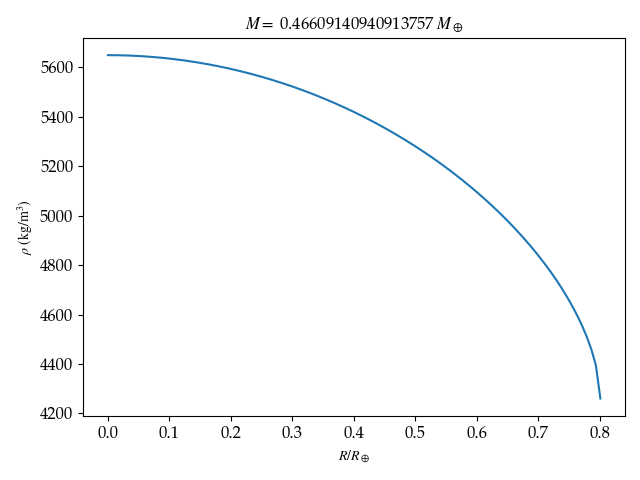

In [5]:
w_pc = widgets.FloatLogSlider(
    value=1.0e10,
    min=10,
    max=17,
    step=0.1,
    description=r'$P_c$:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.4f',
)

w_material = widgets.Dropdown(
    options=[('Rock', 1), ('Iron', 2), ('Water', 3)],
    value=1,
    description='Material:',
)

# Display slider
output = widgets.Output()
display(w_pc, output)
display(w_material, output)

fig1, ax1 = plt.subplots(num='Density profile')

ax1.set_xlabel(r'$R/R_\oplus$')
ax1.set_ylabel(r'$\rho~(\mathrm{kg/m^3})$')
  
p_curr = p_rock
Pc = 1.0e11
mass, radius = p_curr.manifold(np.asarray([Pc]))
r = np.logspace(np.log10(radius)-4, np.log10(radius), 1000)
dens = p_curr.single_solution(Pc, r)


ax1.set_title(r'$M = $ {} $M_\oplus$'.format(mass[0]/me) )
line, = ax1.plot(r/re, dens)

plt.tight_layout()

def on_value_change_pc(change):
    with output:
        global Pc, p_curr
        Pc = change['new']
         
        mass, radius = p_curr.manifold(np.asarray([Pc]))
        r = np.logspace(np.log10(radius)-4, np.log10(radius), 1000)
        dens = p_curr.single_solution(Pc, r)


        ax1.set_title(r'$M = $ {} $M_\oplus$'.format(mass[0]/me) )

        line.set_data(r/re, dens);

        ax1.relim()
        ax1.autoscale()
        plt.tight_layout()

def on_value_change_material(change):
    with output:
        global Pc, p_curr
        c = change['new']
         
        if (c == 1):
            p_curr = p_rock
        if (c == 2):
            p_curr = p_iron
        if (c == 3):
            p_curr = p_water
            
        mass, radius = p_curr.manifold(np.asarray([Pc]))
        r = np.logspace(np.log10(radius)-4, np.log10(radius), 1000)
        dens = p_curr.single_solution(Pc, r)


        ax1.set_title(r'$M = $ {} $M_\oplus$'.format(mass[0]/me) )

        line.set_data(r/re, dens);

        ax1.relim()
        ax1.autoscale()
        plt.tight_layout()
 
w_pc.observe(on_value_change_pc, names='value')
w_material.observe(on_value_change_material, names='value')


1. For what masses is the constant density equation of state reasonable? 
2. How does this depend on the material? 
3. Do the solutions at the high-mass end look like what you would expect from Exercise Sheet 3 ('Water Worlds')?
4. What is the average density at the high-mass end and how does this compare with the low-mass end?

## Mass-Radius relationship

For every value of the central pressure, we get a valid planet model (within the limits of the equation of state). Each model has a mass and a radius, so for every equation of state we have a mass-radius relationship. Below, as in the previous notebook we use the [open exoplanet catalogue](http://www.openexoplanetcatalogue.com/) to plot the most recent masses and radii of all known extrasolar planets. This time, we overlay the mass-radius relationships for solid planets for three different materials. 

<IPython.core.display.Javascript object>


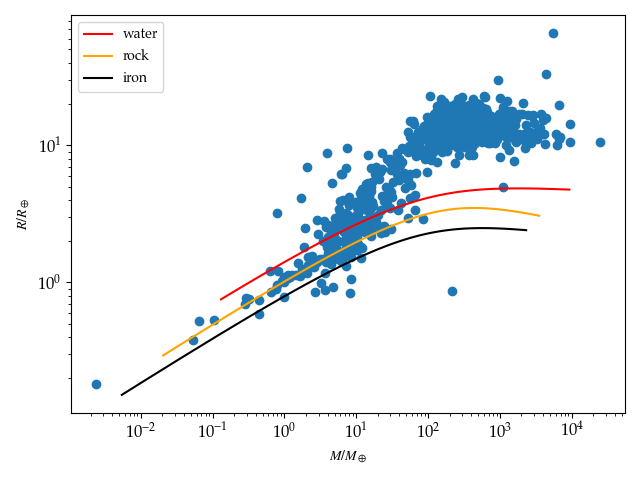

In [4]:
pressure = np.logspace(10, 17, 100)
mass, radius = p_water.manifold(pressure)

fig2, ax2 = plt.subplots(num='Mass-Radius relationships')

ax2.set_xlabel(r'$M/M_\oplus$')
ax2.set_ylabel(r'$R/R_\oplus$')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.plot(mass/me, radius/re, label='water', color='red')

pressure = np.logspace(10, 17, 100)
mass, radius = p_rock.manifold(pressure)
ax2.plot(mass/me, radius/re, label='rock', color='orange')

pressure = np.logspace(10, 17, 100)
mass, radius = p_iron.manifold(pressure)
ax2.plot(mass/me, radius/re, label='iron', color='black')

ax2.legend()

sp2 = ScatterPlot(fig2, ax2, np.asarray(oec_mass)*mjup/me, np.asarray(oec_radius)*rjup/re, oec_names)
#plt.plot([7.3], [1.55], marker='o')
#plt.plot([40.0], [0.307*rjup/re], marker='o')

1. Can you identify some of the Solar system planets? Are they fairly typical?
2. Look up some potential water worlds either in the [open exoplanet catalogue](http://www.openexoplanetcatalogue.com/) or on Google. Are they truly thought to be water worlds? If not, can you think of any reason why not?
3. Look up the most massive solid planet in the diagram. Same for the most massive rocky planet. 
4. Some planets fall below the iron curve. Do you think that is problematic?
5. Look up a few of these extremely dense planets in the [open exoplanet catalogue](http://www.openexoplanetcatalogue.com/) and look critically at the mass and radius measurements and their errors. Could they be consistent with being pure iron, given the uncertainties?